# Data Import

## Library Imports

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import argmax
import cv2
import glob
import pydicom as dicom
import random as ran
from scipy.ndimage.interpolation import rotate

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from skmultilearn.problem_transform import BinaryRelevance

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.regularizers import l2, l1
from keras.optimizers import SGD

## Training Label CSV Transformation

The training labels come in the format:

<table>
    <tr>
        <th>
            ID
        </th>
        <th>
            Label
        </th>
    </tr>
    <tr>
        <td>
            12345_intraparenchymal
        </td>
        <td>
            1
        </td>
    </tr>
    <tr>
        <td>
            12345_subarachnoid
        </td>
        <td>
            0
        </td>
    </tr>
    <tr>
        <td>
            12345_subdural
        </td>
        <td>
            1
        </td>
    </tr>
    <tr>
        <td>
            12345_intraventricular
        </td>
        <td>
            0
        </td>
    </tr>
    <tr>
        <td>
            12345_epidural
        </td>
        <td>
            0
        </td>
    </tr>
    <tr>
        <td>
            12345_any
        </td>
        <td>
            1
        </td>
    </tr>
</table>

Where each patient ID (`ID`) has six individual rows, each one providing one of the six forms of hemorrhaging along with a boolean column indicating whether that type of hemorrhaging is present in the image.

This format requires some transformation before it can be used in a model. All patient IDs on a single row, with a list of hemorrhage types indicating which are present in that ID will be much more conducive to one hot encoding and eventual classification.

To do this, first I needed to separate the data into two pd.Series; one for IDs that did have hemorrhaging and one for IDs with no hemorrhaging. This is because of the six row per ID format, I needed to perform different transformations on positive and negative IDs. After this, all that was required was grouping by the IDs, then performing the specific transformation for each type of label. The results was:

<table>
    <tr>
        <th>
            ID
        </th>
        <th>
            hem
        </th>
    </tr>
    <tr>
        <td>
            ID_12345
        </td>
        <td>
            [intraparenchymal, subdural, any]
        </td>
    </tr>
    <tr>
        <td>
            ID_22345
        </td>
        <td>
            [subarachnoid, any]
        </td>
    </tr>
    <tr>
        <td>
            ID_32345
        </td>
        <td>
            [none]
        </td>
    </tr>
</table>

In [10]:
train_csv = pd.read_csv('C:/users/sourp/documents/github_repos/ihd_data/data/stage_1_train.csv')
#train_csv = pd.read_csv("./data/stage_1_train.csv")
print('Length of train_csv:',str(len(train_csv)))
print('Expected length of post-transform train_labels:', str(int(len(train_csv)/6)))

train_csv = train_csv[~train_csv.ID.str.contains('any')]
train_csv['hem'] = train_csv['ID'].str.split('_').str[2]

train_labels_pos = train_csv.loc[train_csv['Label']==1].groupby([train_csv['ID'].str.split('_').str[1]
                                                                ])['hem'].apply(lambda x: "%s" % '_'.join(x))
train_labels_neg = train_csv.groupby([train_csv["ID"].str.split("_").str[1]]).sum()
train_labels_neg[train_labels_neg == 0] = 'none'
train_labels_neg = train_labels_neg[train_labels_neg == 'none']
train_labels_neg.dropna(inplace=True)

train_labels = train_labels_pos.append(train_labels_neg['Label'])
print(train_labels.head())

train_labels.index = 'ID_'+train_labels.index
train_labels = train_labels.str.split('_')

print(train_labels.head())
print('Training labels created.\nLength of train_labels: '+str(len(train_labels)))

Length of train_csv: 4045572
Expected length of post-transform train_labels: 674262
ID
0002081b6         intraparenchymal
0002a38ad    subarachnoid_subdural
000346ce2                 subdural
00042829c         intraventricular
0004a5701                 subdural
dtype: object
ID_0002081b6          [intraparenchymal]
ID_0002a38ad    [subarachnoid, subdural]
ID_000346ce2                  [subdural]
ID_00042829c          [intraventricular]
ID_0004a5701                  [subdural]
dtype: object
Training labels created.
Length of train_labels: 674258


## Images Import and Labeling

The images come in the dicom image format. This format is one of the standard image formats for CT scan images and has a unique and helpful feature in the form of metadata.

With this robust metadata, you can have access to many different attributes and labels associated with the image. Using the format `image.attribute` you can access this information.

In this case, I need the `image.pixel_array` to actually load the image into python and `image.SOPInstanceUID` which is the patient ID I can then use to match up images with their respective training label.

All images are then loaded into an np.array, then transferred to a dictionary in one key, while a second key holds the labels for each image.

In [11]:
def import_images(total_images, hem_rate):
    image_arrays = []
    labels = []
    image_counter = 0
    total_images = total_images
    hem_img_count = 0
    total_hem_img_count = int(total_images*hem_rate)

    files = glob.glob("C:/users/sourp/documents/github_repos/ihd_data/data/stage_1_train_images/*.dcm")
    #files = glob.glob("./data/stage_1_train_images/*.dcm")
    ran.shuffle(files)

    for im_file in files:
        if image_counter < total_images:
            try:
                image = dicom.dcmread(im_file)
                image_array = image.pixel_array
                image_array_resized = cv2.resize(image_array,(50,50))
                image_label = train_labels.loc[train_labels.index==str(image.SOPInstanceUID)][0]

                if 'none' not in image_label and hem_img_count < total_hem_img_count:
                    if image_counter % 1000 == 0 and image_counter != 0:
                        print(str(image_counter), 'images imported.')
                    image_arrays.append(image_array_resized)
                    labels.append(image_label)
                    hem_img_count += 1
                    image_counter += 1
                elif hem_img_count >= total_hem_img_count:
                    if image_counter % 1000 == 0 and image_counter != 0:
                        print(str(image_counter), 'images imported.')
                    image_arrays.append(image_array_resized)
                    labels.append(image_label)
                    image_counter += 1    
            except:
                pass
        else:
            break

    print('Import complete.'+'\n\n'+'images: ' + str(image_counter)+'\n')

    image_arrays, labels = shuffle(np.asarray(image_arrays), np.asarray(labels), random_state=0)
    data = {'images': image_arrays, 'labels': labels}
    
    print(data['images'][0],'\n\n',data['labels'][0])
    
    return data

In [12]:
data = import_images(100000, .75)
test_data = import_images(25000, .75)

1000 images imported.
2000 images imported.
3000 images imported.
4000 images imported.
5000 images imported.
6000 images imported.
7000 images imported.
8000 images imported.
9000 images imported.
10000 images imported.
11000 images imported.
12000 images imported.
13000 images imported.
14000 images imported.
15000 images imported.
16000 images imported.
17000 images imported.
18000 images imported.
19000 images imported.
20000 images imported.
21000 images imported.
22000 images imported.
23000 images imported.
24000 images imported.
25000 images imported.
26000 images imported.
27000 images imported.
28000 images imported.
29000 images imported.
30000 images imported.
31000 images imported.
32000 images imported.
33000 images imported.
34000 images imported.
35000 images imported.
36000 images imported.
37000 images imported.
38000 images imported.
39000 images imported.
40000 images imported.
41000 images imported.
42000 images imported.
43000 images imported.
44000 images importe

For the sake of testing, both pieces of data are read into DataFrames, then written to CSVs, so the images won't need to be imported every time.

In [46]:
training_data_array = data['images']
training_labels_array = data['labels']

test_data_array = test_data['images']
test_labels_array = test_data['labels']

np.save('./data/training_data_array.npy', training_data_array)
np.save('./data/training_labels_array.npy', training_labels_array)

np.save('./data/test_data_array.npy', test_data_array)
np.save('./data/test_labels_array.npy', test_labels_array)

In [47]:
training_data_array = np.load('./data/training_data_array.npy')
training_labels_array = np.load('./data/training_labels_array.npy')

tdata = {'images':training_data_array,'labels':training_labels_array}

#test_data_array = np.load('./data/test_data_array.npy')
#test_labels_array = np.load('./data/test_labels_array.npy')

# Data Examination

## Image Example

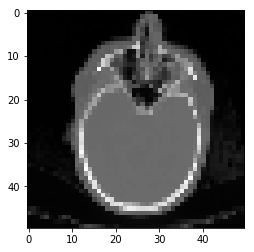

In [69]:
random_index = ran.randint(0, 99999)
random_scan = data['images'][95878][:,:]/255

plt.imshow(random_scan, cmap='gray');

## Label Information

['epidural'] -- Occurences: 1016
['epidural', 'intraparenchymal'] -- Occurences: 155
['epidural', 'intraparenchymal', 'intraventricular'] -- Occurences: 30
['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid'] -- Occurences: 26
['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural'] -- Occurences: 13
['epidural', 'intraparenchymal', 'intraventricular', 'subdural'] -- Occurences: 11
['epidural', 'intraparenchymal', 'subarachnoid'] -- Occurences: 51
['epidural', 'intraparenchymal', 'subarachnoid', 'subdural'] -- Occurences: 29
['epidural', 'intraparenchymal', 'subdural'] -- Occurences: 56
['epidural', 'intraventricular'] -- Occurences: 22
['epidural', 'intraventricular', 'subarachnoid'] -- Occurences: 8
['epidural', 'intraventricular', 'subarachnoid', 'subdural'] -- Occurences: 21
['epidural', 'intraventricular', 'subdural'] -- Occurences: 8
['epidural', 'subarachnoid'] -- Occurences: 124
['epidural', 'subarachnoid', 'subdural'] -- Occurences: 65
[

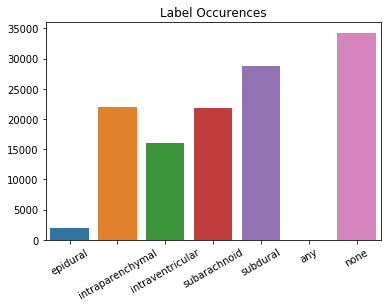

In [14]:
hemorrhages = {'epidural':0,'intraparenchymal':0,'intraventricular':0,'subarachnoid':0,'subdural':0 \
               ,'any':0,'none':0}
unique_labels, label_counts = np.unique(data['labels'], return_counts=True)

index = 0
for i in unique_labels:
    print(i,'-- Occurences:',label_counts[index])
    for k,v in hemorrhages.items():
        if k in i:
            hemorrhages[k] += int(label_counts[index])
    index += 1

ax = sns.barplot(x=list(hemorrhages.keys()), y=list(hemorrhages.values()))
ax.title.set_text('Label Occurences')
ax.set_xticklabels(labels = list(hemorrhages.keys()),rotation=30)
plt.show()

## Correlation

To examine how often hemorrhaging types occur with each other, I create a DataFrame whose columns are the types and whose values are a boolean indicating if that hemorrhaging type occurs in that label. This is then mapped to a DataFrame shaped like a matrix, where the columns and indexes are both type names, and the rate of cross-occurences are the values. This is then plotted on a heatmap.

   subdural  epidural  intraparenchymal  intraventricular  subarachnoid   none
0     False     False             False              True         False  False
1     False     False             False             False         False   True
2     False     False             False              True         False  False
3     False     False              True             False         False  False
4     False     False              True             False         False  False


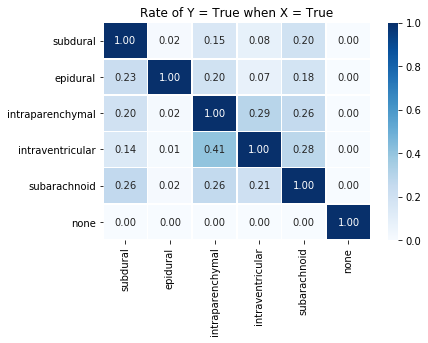

In [20]:
labels = {'subdural':[],'epidural':[],'intraparenchymal':[],'intraventricular':[],'subarachnoid':[],'none':[]}

for i in data['labels']:
    for k,v in labels.items():
        if k in i:
            v.append(True)
        else:
            v.append(False)

label_ovlp_df = pd.DataFrame(labels)
print(label_ovlp_df.head())

label_ovlp_rt_df = pd.DataFrame(index=list(labels.keys()), columns=list(labels.keys()))
label_ovlp_rt_df = label_ovlp_rt_df.astype(float)

for i in list(labels.keys()):
    for j in list(labels.keys()):
        label_ovlp_rt_df.loc[i,j] = len(label_ovlp_df[label_ovlp_df[[i,j]].eq(True).all(axis=1)])/ \
            len(label_ovlp_df[label_ovlp_df[i].eq(True)])

ax = sns.heatmap(label_ovlp_rt_df, vmin=0, vmax=1, annot=True, fmt='.2f', linewidth=.5, cmap='Blues')
ax.title.set_text('Rate of Y = True when X = True')
plt.show()

# Data Cleaning

## Minority Over-sampling
Due to the distribution of labels seen above, there is a risk that the data will be biased towards certain labels. To prevent this, I implement an over-sampling technique inspired by SMOTE, to even out the labels.

In [106]:
epid_indexes = []
sudu_indexes = []
inpa_indexes = []
inve_indexes = []
suar_indexes = []
none_indexes = []

it = np.nditer(data['labels'], flags=['f_index', 'refs_ok'])
while not it.finished:
    if 'epidural' in it[0].tolist():
        epid_indexes.append(it.index)
    if 'subdural' in it[0].tolist():
        sudu_indexes.append(it.index)
    if 'intraparenchymal' in it[0].tolist():
        inpa_indexes.append(it.index)
    if 'intraventricular' in it[0].tolist():
        inve_indexes.append(it.index)
    if 'subarachnoid' in it[0].tolist():
        suar_indexes.append(it.index)
    if 'none' in it[0].tolist():
        none_indexes.append(it.index)
    it.iternext()

In [110]:
print(' ',len(epid_indexes),'\n',len(sudu_indexes),'\n',len(inpa_indexes),'\n',len(inve_indexes),'\n' \
     ,len(suar_indexes),'\n',len(none_indexes))


  1867 
 28801 
 22019 
 16023 
 21745 
 34287


# Data Transformation

In [49]:
X_temp = tdata['images']/255

X = np.empty(shape=[X_temp.shape[0]] + [2500], dtype='float32')
print(X_temp.shape)

for im in range(X_temp.shape[0]):
    X[im,:] = X_temp[im,:,:].flatten()

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(tdata['labels'])

print(y[:10])
print(X_temp.shape)
print(X.shape)
print(y.shape)
X[0,:]

(100000, 50, 50)
[[0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 1 1 0 0 0]
 [0 0 0 0 0 1]]
(100000, 50, 50)
(100000, 2500)
(100000, 6)


array([0.44313726, 0.43137255, 0.43137255, ..., 0.8627451 , 0.84705883,
       0.83137256], dtype=float32)

In [50]:
# Neural Network train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=50)

print (X_train.shape)
print (y_train.shape)

(75000, 2500)
(75000, 6)


In [51]:
stdscaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = stdscaler.transform(X_train)
X_test_scaled  = stdscaler.transform(X_test)

# Neural Network Model

In [52]:
label_count = len(mlb.classes_)

model = Sequential()

model.add(Dense(label_count*24, input_shape=[2500], activation='relu', W_regularizer=l2(0.1)))
model.add(Dense(label_count*18, activation='relu', W_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(label_count*12, activation='relu', W_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(label_count*8, activation='relu', W_regularizer=l2(0.001)))
model.add(Dense(label_count, activation='sigmoid', W_regularizer=l1(0.001)))

sgd = SGD(lr=0.1)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

C:\Users\sourp\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(144, input_shape=[2500], activation="relu", kernel_regularizer=<keras.reg...)`
  """
C:\Users\sourp\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(108, activation="relu", kernel_regularizer=<keras.reg...)`
  
C:\Users\sourp\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(72, activation="relu", kernel_regularizer=<keras.reg...)`
  
C:\Users\sourp\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(48, activation="relu", kernel_regularizer=<keras.reg...)`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\sourp\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(6, activation

In [53]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 144)               360144    
_________________________________________________________________
dense_17 (Dense)             (None, 108)               15660     
_________________________________________________________________
dropout_7 (Dropout)          (None, 108)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 72)                7848      
_________________________________________________________________
dropout_8 (Dropout)          (None, 72)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 48)                3504      
_________________________________________________________________
dense_20 (Dense)             (None, 6)                

In [54]:
history = model.fit(X_train_scaled, y_train, batch_size = 256, 
                    epochs = 50, verbose=2, validation_data=(X_test_scaled, y_test))

Train on 75000 samples, validate on 25000 samples
Epoch 1/50
 - 4s - loss: 4.1686 - accuracy: 0.7956 - val_loss: 1.2033 - val_accuracy: 0.8076
Epoch 2/50
 - 3s - loss: 0.9346 - accuracy: 0.8074 - val_loss: 0.7402 - val_accuracy: 0.8102
Epoch 3/50
 - 3s - loss: 0.6560 - accuracy: 0.8085 - val_loss: 0.5897 - val_accuracy: 0.8096
Epoch 4/50
 - 3s - loss: 0.5627 - accuracy: 0.8088 - val_loss: 0.5365 - val_accuracy: 0.8110
Epoch 5/50
 - 3s - loss: 0.5282 - accuracy: 0.8092 - val_loss: 0.5142 - val_accuracy: 0.8108
Epoch 6/50
 - 3s - loss: 0.5123 - accuracy: 0.8091 - val_loss: 0.5026 - val_accuracy: 0.8104
Epoch 7/50
 - 3s - loss: 0.5031 - accuracy: 0.8095 - val_loss: 0.4970 - val_accuracy: 0.8100
Epoch 8/50
 - 3s - loss: 0.4970 - accuracy: 0.8095 - val_loss: 0.4900 - val_accuracy: 0.8106
Epoch 9/50
 - 3s - loss: 0.4919 - accuracy: 0.8093 - val_loss: 0.4866 - val_accuracy: 0.8106
Epoch 10/50
 - 3s - loss: 0.4879 - accuracy: 0.8093 - val_loss: 0.4810 - val_accuracy: 0.8116
Epoch 11/50
 - 3s -

BC after final iteration:  0.4615072406291962


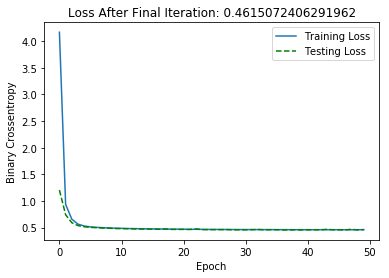

In [55]:
fig = plt.figure(figsize=(6,4))

# Summary of loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], 'g--')
plt.title('Model Loss')
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Testing Loss'], loc='upper right')
plt.title('Loss After Final Iteration: '+str(history.history['val_loss'][-1]))
print ("BC after final iteration: ", history.history['val_loss'][-1])
plt.show()

Accuracy after final iteration:  0.8082000017166138


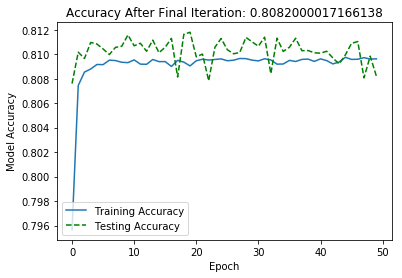

In [56]:
fig = plt.figure(figsize=(6,4))

# Summary of accuracy history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], 'g--')
plt.title('Model Accuracy')
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='lower left')
plt.title('Accuracy After Final Iteration: '+str(history.history['val_accuracy'][-1]))
print ("Accuracy after final iteration: ", history.history['val_accuracy'][-1])
plt.show()

## Test Model

In [29]:
test_X_temp = test_data['images']/255

test_X = np.empty(shape=[test_X_temp.shape[0]] + [2500], dtype='float32')
print(test_X_temp.shape)

for im in range(test_X_temp.shape[0]):
    test_X[im,:] = test_X_temp[im,:,:].flatten()

test_mlb = MultiLabelBinarizer()
test_y = test_mlb.fit_transform(test_data['labels'])

print(test_y[:10])
print(test_X_temp.shape)
print(test_X.shape)
print(test_y.shape)
test_X[0,:]

test_stdscaler = preprocessing.StandardScaler().fit(test_X)

test_X_scaled = test_stdscaler.transform(test_X)
#test_X_test_scaled  = test_stdscaler.transform(X_test)

(25000, 50, 50)
[[0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 1 0 0]]
(25000, 50, 50)
(25000, 2500)
(25000, 6)


In [30]:
test_y_pred = model.predict(test_X_scaled, batch_size=256, verbose=2)
test_y_actual = np.argmax(test_y_pred, axis=1)

In [43]:
print(test_y_pred[0])
print(test_y[0])

<class 'numpy.ndarray'>
[0 1 0 0 0 0]


In [83]:
print(classification_report(test_y_pred, test_y_actual))

ValueError: Classification metrics can't handle a mix of continuous-multioutput and binary targets

In [44]:
test_y_pred_rounded = np.around(test_y_pred)

In [45]:
test_y_pred_rounded[0]

array([0., 0., 0., 0., 0., 0.], dtype=float32)